# Statistical Plan

This document is dedicated for detailed explanation of statistical analysis of M.O.R.E. (Masked Object Recognition Experiment). We will start with detailed explanation of the data itself. Overall we collected 22 different type of data where we will mention here the ones related with the analysis (for the rest please see "fulldataset.csv") .

**1) Participant Number:** Number of the participant, overall we have 30 participants. |pt_num|

**2) Trial Number:** As the name suggest corresponding trial number; for each participant whole experiment consisted of 1440 trials (excluding the training phase). |trial_nbr|

**3) Block Number:** Overall, experiment consists of 10 blocks (and 9 break in between the blocks), thus each block contained of 144 trials. |block_number|

**4) Reaction Time:** One of the key data to be analyzed, recorded reaction time given to a trial, a timer sets on after the stimulus presentation until a response with key is given. Clarification, reaction time does not include stimulus presentation only the time after stimulus presentation and until a key is pressed. maximum of 10 seconds window was allowed if no response given within this 10 seconds; next trial begins. |rt|

**5) Stimulus Onset Asynchrony (SOA):** This terms is currently a bit misleading, we mean duration of stimulus presented (time that image stayed on the screen), this changed across the experiment to be 25ms, 50ms and 100ms. Each duration type was evenly distributed (in a randomized order) through the experiment 480 trial per type. |soa|

**6) Accuracy:** Registry of whether a participant correctly chose the the category of the given stimuli. Thus, it is either TRUE or FALSE. |acc|

**7) Category:** Category of the presented object, one of the following options: bird, tree, cat, building, bus, person, fire hydrant, banana. |category|

**8) Chosen Category:** Response of the participant selecting the category of the object. |choiced_category|

**9) Difficulty:** Difficulty of the occlusion (how much of the image is being occluded), control = no occlusion, low = smaller occlusion, high = greater occlusion. |difficulty|.

**10) Size of Occlusion:** As we opted for partial viewing occlusion type, this occlusion also differs into two, having few but large blobs blocking the image, and many but small images blocking the image, |size_occl|

**11) Pressed Key:** Which key was pressed to give response to the trial? We recorded each pressed key per trial. |pressed_key|

**12) Correct Key:** This holds the value which key was supposed to be pressed in order to give the correct answer. |correct_key|





*Overall, we have had 3 different effect parameters (SOA, Difficulty and Size of Occlusion) that is hypothesized to influence the accuracy and the reaction time.*

## Processing Data

We must start with importing necessary libraries, datasets and merging everything into one big set. Where we will start with data cleaning and determination of outliers. 

In [1]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import statistics
import pingouin as pg
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:

# use a personal style sheet
plt.style.use("./styles/mystyle.mplstyle")

# listing all the current data
data_files = glob.glob(r'../Experiment/data/*.csv') # taking only the two complete files

df = pd.DataFrame()
df = pd.concat([ pd.read_csv(file) for file in data_files ])

# select only the main task
df = df.loc[df['task']=='experiment']

# dropping unnecessary columns in terms of data analysis
df = df.drop(labels = ["Age", "Gender", "Handedness", "manipulation", "mask", "type_occl", "filename",
                       "mask_filename", "task", "Experiment Duration", "Version"], axis=1)
df = df.reset_index(drop = True)

# extracting sample size
n = len(set(df.pt_num))
print(n)
# 
df.head()
#Overall trial number
len(df.index) #43200

30


43200

### Managing Missing Datapoints and Outlier Determination

Now as we have our merged dataset available to us (df) we now should start with close inspection of the datasets, this including managing missing datapoints. Coding of the experiment allow us to easily find such occasion, we will be looking for a reaction time higher-equal to 10 and pressed key is to be "NAN". we will remove such rows from the dataset.



In [3]:
nan = df[df["pressed_key"] == "NAN"].index
# there is only one occasion where there is NAN,  participant-19, trial number 1122
# magic number remove this 

In [4]:
df = df.drop(nan, axis = 0) #remove it via lable that makes sense

In [5]:
df[df["pressed_key"] == "NAN"]
# Now it is removed

,pt_num,trial_nbr,block_number,rt,soa,acc,category,choiced_category,difficulty,size_occl,pressed_key,correct_key


**For outliers**: 99th percentile cut-off value will be employed when it comes to reaction time. Also for the accuracy we will check if any participant is close to (or even below) of a chance level which is 12.5% given that there are 8 possible options to be chosen. These outliers will be removed from the dataset. Let us start with averages of each participant.

## Inspecting plots for Outliers

Overall Average of Accuracy 0.8608301118081437
Overall Average of Reaction Time 0.9536470651404071


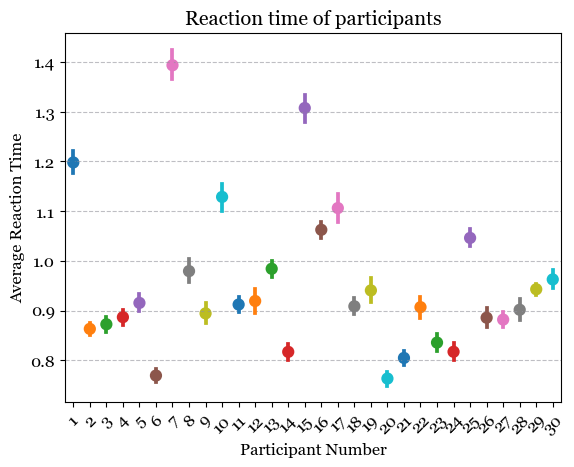

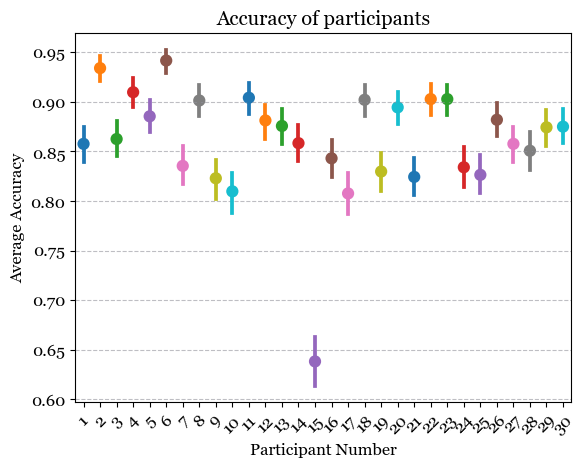

In [6]:
plt.figure()
plot = sns.pointplot(
data = df,
y = 'rt',
x = 'pt_num',
#order = ['cat', 'bird', 'firehydrant','person', 'banana','bus','building', 'tree'],
# hue = 'soa',
# hue = 'size_occl',
palette = 'tab10',
)
plt.xticks(rotation= 45)
plt.title("Reaction time of participants")
plt.ylabel("Average Reaction Time")
plt.xlabel("Participant Number")

plt.figure()
plot = sns.pointplot(
data = df,
y = 'acc',
x = 'pt_num',
#order = ['cat', 'bird', 'firehydrant','person', 'banana','bus','building', 'tree'],
# hue = 'soa',
# hue = 'size_occl',
palette = 'tab10',
)
plt.xticks(rotation= 45)
plt.ylabel("Average Accuracy")
plt.xlabel("Participant Number")
plt.title("Accuracy of participants")

print("Overall Average of Accuracy " +str(statistics.mean(df["acc"])))
print("Overall Average of Reaction Time " +str(statistics.mean(df["rt"])))

**Reaction time plot** shows very heterogeneous distribution. Outliers will be identified using 99th percentile and removed.
 
**Accuracy plot** shows rather stable accuracy levels across participants except participant-15 where participants score 65% correct while the average is 86%. For that reason participant 15 will be removed from further analysis as being an outlier participant.

43199
41759


Text(0.5, 1.0, 'Accuracy of participants')

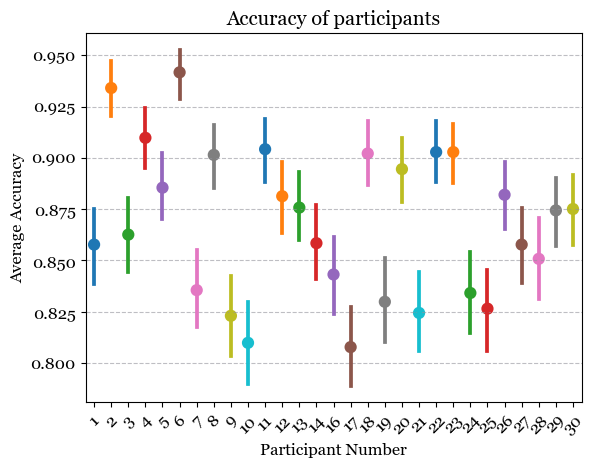

In [7]:
outlier_pt = df[(df["pt_num"] == 15)].index
print(len(df))
df.drop(outlier_pt, inplace = True)
print(len(df))

plt.figure()
plot = sns.pointplot(
data = df,
y = 'acc',
x = 'pt_num',
#order = ['cat', 'bird', 'firehydrant','person', 'banana','bus','building', 'tree'],
# hue = 'soa',
# hue = 'size_occl',
palette = 'tab10',
)
plt.xticks(rotation= 45)
plt.ylabel("Average Accuracy")
plt.xlabel("Participant Number")
plt.title("Accuracy of participants")


**Now as we have removed the participant-15, our next step is to remove the outliers from the reaction time, for that we will be calculating the 99th percentile and we will remove values bigger than 99th percentile. Throughout the notebook, we show how many data points are being dropped due to our outlier decisisions (look for len(df)).

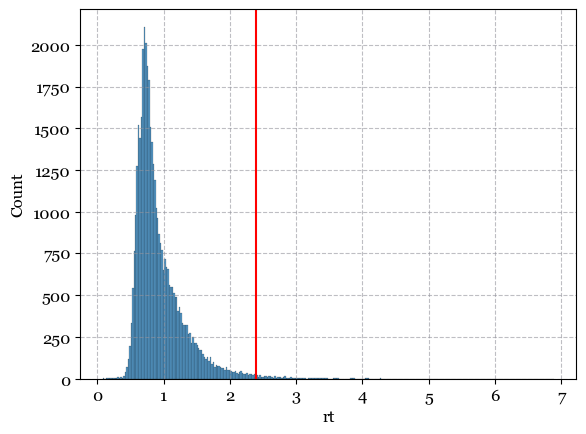

In [8]:
sns.histplot(df["rt"])
ninty_ninth = df["rt"].quantile(0.99)
plt.axvline(ninty_ninth, color="red")

In [9]:
df_to_dropped = df[(df["rt"] > ninty_ninth)].index

41759
418
41341


<AxesSubplot:xlabel='rt', ylabel='Count'>

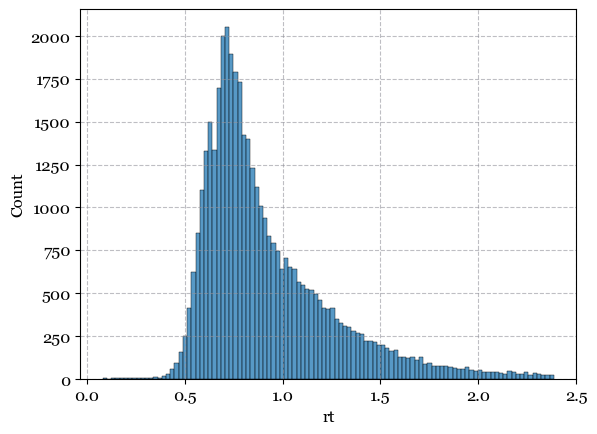

In [10]:
print(len(df))
print(len(df_to_dropped))
df.drop(df_to_dropped, inplace = True)
print(len(df))

sns.histplot(df["rt"])

We also need to remove unlikely small reaction time values, due to nature of the experiment reaction time below 300ms is very unlikely since it is during still presentation of the mask without response set being presented. For that reason we will use quantile value that is approximate to 300ms which is shown below to be 0.001 percentile values below that cut-off will be removed from the data as well.

41341
42
41299


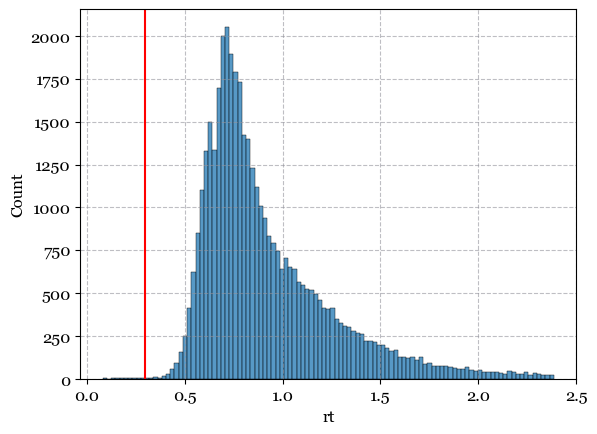

In [11]:
sns.histplot(df["rt"])
zero_point_first_quantile = df["rt"].quantile(0.001)
plt.axvline(zero_point_first_quantile, color="red")

df_to_dropped = df[(df["rt"] < zero_point_first_quantile)].index

print(len(df))
print(len(df_to_dropped))
df.drop(df_to_dropped, inplace = True)
print(len(df))

<AxesSubplot:xlabel='rt', ylabel='Count'>

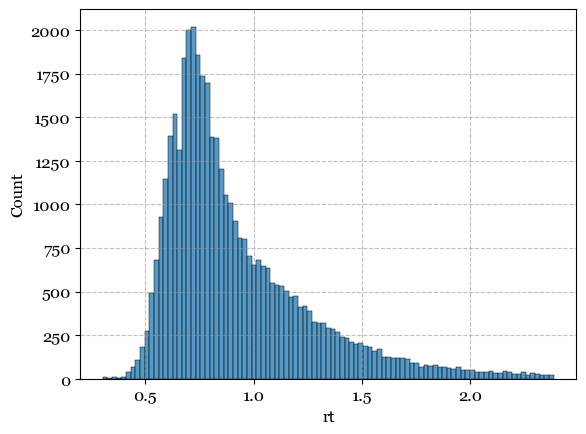

In [12]:
sns.histplot(df["rt"])

**We have removed 418 datapoints that were higher than 99th quantile. This step concludes the pre-processing stage of data, initially we have had 43200 trials after preprocessing (exclusion of one participant and reaction times higher than 99th quantile and 0.001 quantile) we are left with 41299. Overall we have rejected 1901 trials. Now we will continue with assumptions check for Anova testing**

## Anova Testing (RT)

### Main Anova size of occlusion x SOA
We only take the true values of accuracy for reaction time anova testing. We also do multiple comparison and do posthoc.

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,size_occl,0.017595,1,28,0.017595,20.822648,0.000091,0.000091,0.007502,1.000000
1,soa,0.009339,2,56,0.004669,7.388909,0.001420,0.002688,0.003996,0.843989
2,size_occl * soa,0.000221,2,56,0.000111,0.239041,0.788182,0.749200,0.000095,0.838085


,0.100,0.050,0.025
0.100,1.000000,0.000022,0.013219
0.050,0.000022,1.000000,0.370207
0.025,0.013219,0.370207,1.000000


,few large,many small
few large,1.000000e+00,3.606678e-08
many small,3.606678e-08,1.000000e+00


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x25115d21e50>)

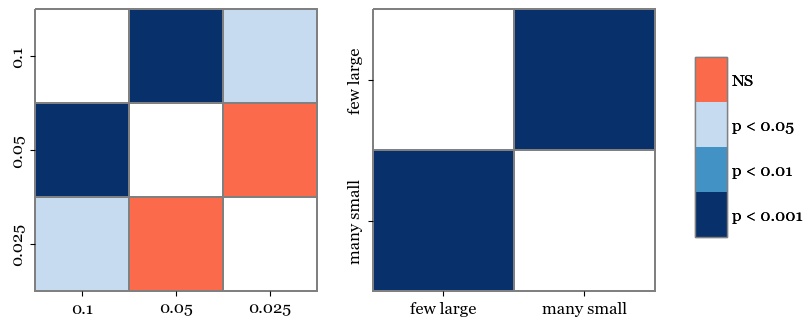

In [13]:
# Main Anova
df_correct =  df[df['acc'] == True]

# Perform Two-Way ANOVA
main_result = pg.rm_anova(data=df_correct, dv='rt', within=['size_occl', 'soa'], subject= 'pt_num', detailed=True)
display(main_result)

#multiple comparisons
posthoc_soa = sp.posthoc_ttest(df_correct, val_col= "rt", group_col= "soa", p_adjust='bonferroni')
display(posthoc_soa)

posthoc_size_occl = sp.posthoc_ttest(df_correct, val_col= "rt", group_col= "size_occl", p_adjust='bonferroni')
display(posthoc_size_occl)

#PLotting them as signplots
fig, ax = plt.subplots(1,2,figsize=(8, 6))
cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.35, 0.04, 0.3]}
sp.sign_plot(posthoc_soa, **heatmap_args, ax =ax[0])

sp.sign_plot(posthoc_size_occl, **heatmap_args, ax= ax[1])

#Down below we do Tukey multiple comparisons

Tukey's HSD post hoc test for 'size_occl':
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2   meandiff p-adj lower  upper  reject
--------------------------------------------------------
few large many small   0.0184   0.0 0.0118 0.0249   True
--------------------------------------------------------
Tukey's HSD post hoc test for 'soa':
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 0.025   0.05  -0.0063 0.2792 -0.0159 0.0034  False
 0.025    0.1   0.0118  0.011  0.0022 0.0213   True
  0.05    0.1    0.018    0.0  0.0086 0.0275   True
---------------------------------------------------


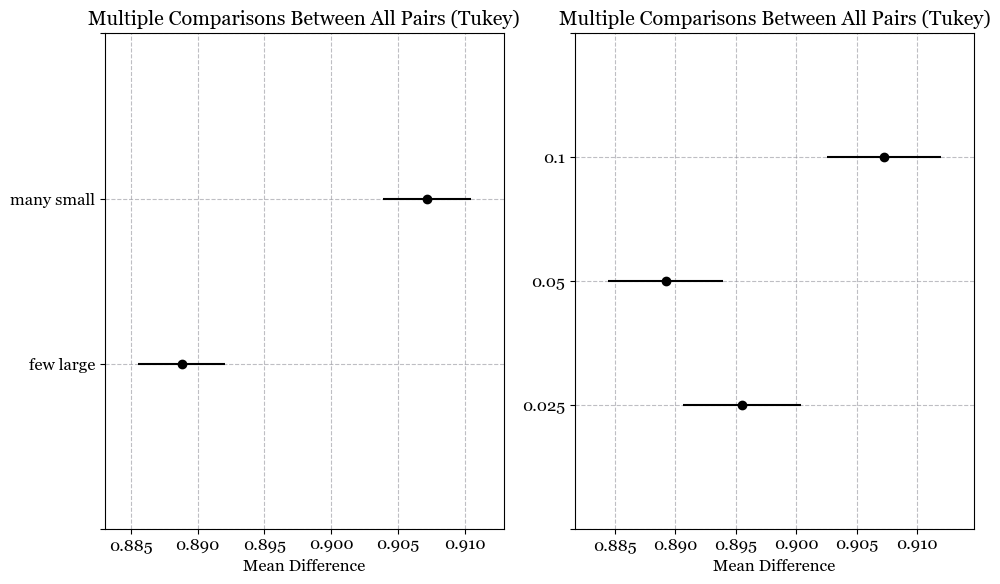

In [14]:
# Bonferroni-corrected post hoc test (Tukey's HSD)
posthoc = pairwise_tukeyhsd(endog=df_correct['rt'], groups=df_correct['size_occl'], alpha=0.05)
print("Tukey's HSD post hoc test for 'size_occl':\n",posthoc)

posthoc1 = pairwise_tukeyhsd(endog=df_correct['rt'], groups=df_correct['soa'], alpha=0.05)
print("Tukey's HSD post hoc test for 'soa':\n", posthoc1)

# Create a bar plot of the differences (optional)
fig, ax = plt.subplots(1,2,figsize=(8, 6))
posthoc.plot_simultaneous(xlabel='Mean Difference', ax=ax[0])
posthoc1.plot_simultaneous(xlabel='Mean Difference', ax=ax[1])
plt.tight_layout()
plt.show()

### Assumption Checks for Main Anova
Since it is repeated measures of Anova, we have three assumptions to meet:

1. Independence: Each of the observations should be independent.

2. Normality: The distribution of the response variable is normally distributed.

3. Sphericity: The variances of the differences between all combinations of related groups must be equal.

Due to nature of experimental design we have no reason to suspect assumption of independence to be violated.
We can test for 2nd and the 3rd via checks

SpherResults(spher=True, W=3003.61397672277, chi2=-216.2044305415396, dof=2, pval=1.0)

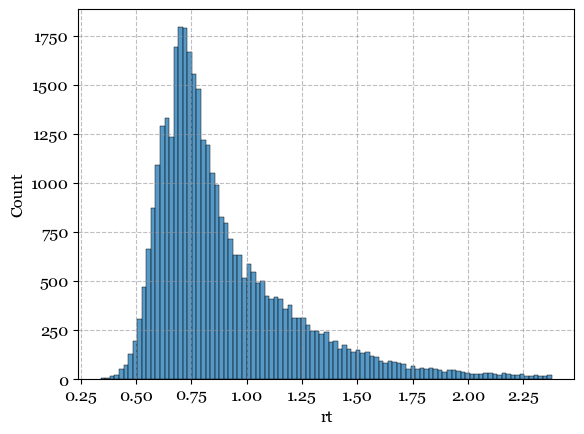

In [15]:
sns.histplot(df_correct["rt"])

sphere_check = pg.sphericity(df_correct, dv="rt", within=['size_occl', 'soa'], subject= 'pt_num', method='mauchly', alpha=0.05)
sphere_check

**Normality:** Due to the nature of data itself data distribution is skewed, 
though repeated measures are usually considered as robust against such violation if there is enough datapoints
which in our case we do have high datapoints.

**Sphericity:** Mauchly test shows no significant result on violation of sphericity assumptions. We can conclude that sphericity assumption is met.

### Sub-Anova on many small checking for effects of difficulty X Soa

C:\Users\veoni\anaconda3\lib\site-packages\pingouin\distribution.py:515: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn(


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,difficulty,0.382962,2,56,0.191481,69.298306,7.136366e-16,1.428378e-13,0.090164,0.830728
1,soa,0.013710,2,56,0.006855,3.573610,3.462151e-02,4.776422e-02,0.003535,0.769250
2,difficulty * soa,0.014817,4,112,0.003704,2.343339,5.910163e-02,8.829592e-02,0.003820,0.652795


,control,low,high
control,1.000000e+00,2.163631e-21,6.961069e-45
low,2.163631e-21,1.000000e+00,2.453616e-06
high,6.961069e-45,2.453616e-06,1.000000e+00


,0.100,0.050,0.025
0.100,1.000000,0.000986,0.105172
0.050,0.000986,1.000000,0.507985
0.025,0.105172,0.507985,1.000000


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x251183044f0>)

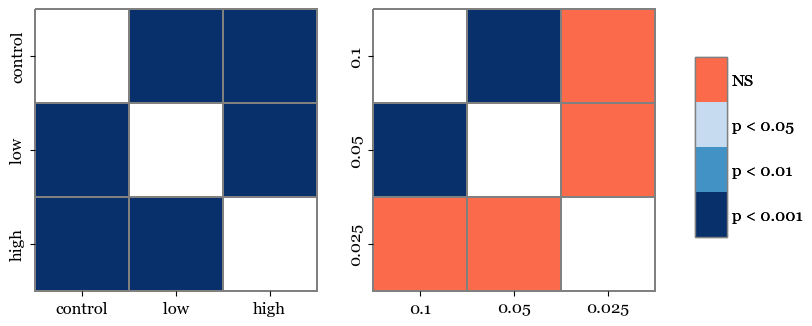

In [16]:
#Occluder size many small
df_many_small = df[(df['size_occl'] == "many small") & df['acc'] == True ]

many_small_anova = pg.rm_anova(data= df_many_small, dv='rt', within=["difficulty", 'soa'], subject = "pt_num", detailed = True)
display(many_small_anova)

posthoc_soa = sp.posthoc_ttest(df_many_small, val_col= "rt", group_col= "difficulty", p_adjust='bonferroni')
display(posthoc_soa)

posthoc_size_occl = sp.posthoc_ttest(df_many_small, val_col= "rt", group_col= "soa", p_adjust='bonferroni')
display(posthoc_size_occl)

#PLotting them as signplots
fig, ax = plt.subplots(1,2,figsize=(8, 6))
cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.35, 0.04, 0.3]}
sp.sign_plot(posthoc_soa, **heatmap_args, ax =ax[0])

sp.sign_plot(posthoc_size_occl, **heatmap_args, ax= ax[1])

#Down below we do Tukey multiple comparisons

Tukey's HSD post hoc test for 'size_occl':
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj  lower   upper  reject
----------------------------------------------------
control   high   0.0849   0.0  0.0709  0.0989   True
control    low   0.0545   0.0  0.0413  0.0677   True
   high    low  -0.0304   0.0 -0.0449 -0.0159   True
----------------------------------------------------
Tukey's HSD post hoc test for 'soa':
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 0.025   0.05  -0.0082 0.3589 -0.0223 0.0059  False
 0.025    0.1   0.0126  0.084 -0.0013 0.0265  False
  0.05    0.1   0.0208  0.001  0.0072 0.0345   True
---------------------------------------------------


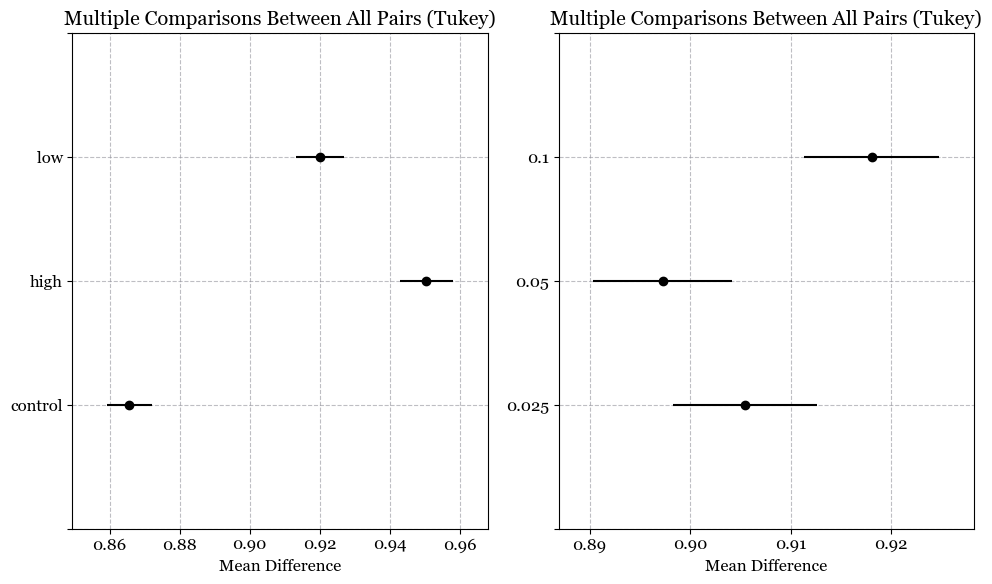

In [17]:
# Bonferroni-corrected post hoc test (Tukey's HSD)
posthoc = pairwise_tukeyhsd(endog=df_many_small['rt'], groups=df_many_small['difficulty'], alpha=0.05)
print("Tukey's HSD post hoc test for 'size_occl':\n",posthoc)

posthoc1 = pairwise_tukeyhsd(endog=df_many_small['rt'], groups=df_many_small['soa'], alpha=0.05)
print("Tukey's HSD post hoc test for 'soa':\n", posthoc1)

# Create a bar plot of the differences (optional)
fig, ax = plt.subplots(1,2,figsize=(8, 6))
posthoc.plot_simultaneous(xlabel='Mean Difference', ax=ax[0])
posthoc1.plot_simultaneous(xlabel='Mean Difference', ax=ax[1])
plt.tight_layout()
plt.show()

### Assumption Checks
Since it is repeated measures of Anova, we have three assumptions to meet:

1. Independence: Each of the observations should be independent.

2. Normality: The distribution of the response variable is normally distributed.

3. Sphericity: The variances of the differences between all combinations of related groups must be equal.

Due to nature of experimental design we have no reason to suspect assumption of independence to be violated.
We can test for 2nd and the 3rd via checks

<AxesSubplot:xlabel='rt', ylabel='Count'>

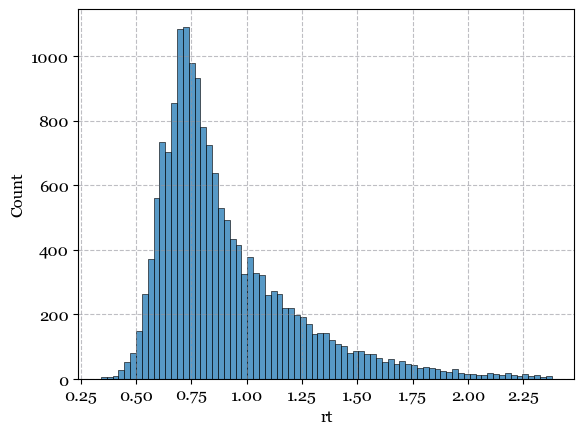

In [18]:
sns.histplot(df_many_small["rt"])

#sphere_check = pg.sphericity(df_many_small, dv="rt", within=['difficulty', 'soa'], subject= 'pt_num', method='mauchly', alpha=0.05)
#sphere_check

# Sphere check will not work due to both factors having 3 levels, pingouin only supports as long as one factor has 2 levels.
# As we have checked thoroughly other libraries does not have this check as well. For this reason we will later incorporate
# R-code to conduct the test for sphericity.

### Sub-Anova on few large checking for effects of difficulty X Soa

C:\Users\veoni\anaconda3\lib\site-packages\pingouin\distribution.py:515: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn(


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,difficulty,0.104859,2,56,0.052429,38.700686,2.784688e-11,6.016698e-10,0.027640,0.853119
1,soa,0.009745,2,56,0.004873,3.438251,3.904722e-02,4.065999e-02,0.002635,0.968883
2,difficulty * soa,0.007706,4,112,0.001926,1.972064,1.036076e-01,1.255251e-01,0.002085,0.737476


,high,low,control
high,1.000000e+00,0.000002,1.040531e-14
low,2.025458e-06,1.000000,7.387535e-03
control,1.040531e-14,0.007388,1.000000e+00


,0.100,0.050,0.025
0.100,1.000000,0.019349,0.21499
0.050,0.019349,1.000000,1.00000
0.025,0.214990,1.000000,1.00000


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x251170167c0>)

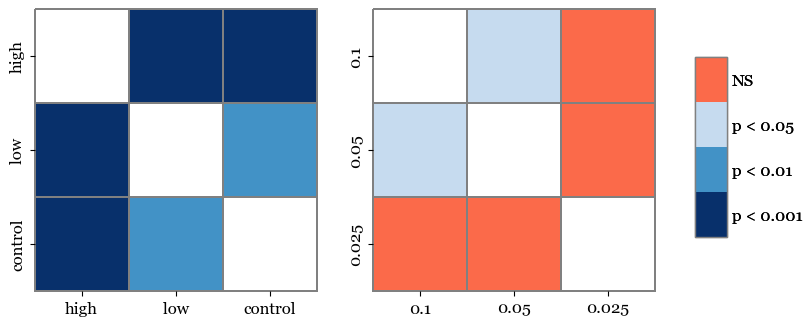

In [19]:
#Occluder size few large
df_few_large = df[(df['size_occl'] == "few large") & df['acc'] == True ]

many_small_anova = pg.rm_anova(data= df_few_large, dv='rt', within=["difficulty", 'soa'], subject = "pt_num", detailed = True)
display(many_small_anova)

posthoc_soa = sp.posthoc_ttest(df_few_large, val_col= "rt", group_col= "difficulty", p_adjust='bonferroni')
display(posthoc_soa)

posthoc_size_occl = sp.posthoc_ttest(df_few_large, val_col= "rt", group_col= "soa", p_adjust='bonferroni')
display(posthoc_size_occl)

#PLotting them as signplots
fig, ax = plt.subplots(1,2,figsize=(8, 6))
cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.35, 0.04, 0.3]}
sp.sign_plot(posthoc_soa, **heatmap_args, ax =ax[0])

sp.sign_plot(posthoc_size_occl, **heatmap_args, ax= ax[1])

#Down below we do Tukey multiple comparisons

Tukey's HSD post hoc test for 'size_occl':
  Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower   upper  reject
-----------------------------------------------------
control   high   0.0448    0.0  0.0316   0.058   True
control    low   0.0168 0.0071  0.0038  0.0297   True
   high    low   -0.028    0.0 -0.0414 -0.0147   True
-----------------------------------------------------
Tukey's HSD post hoc test for 'soa':
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 0.025   0.05  -0.0049 0.6555 -0.0182 0.0083  False
 0.025    0.1   0.0103  0.161 -0.0029 0.0235  False
  0.05    0.1   0.0152 0.0178  0.0021 0.0283   True
---------------------------------------------------


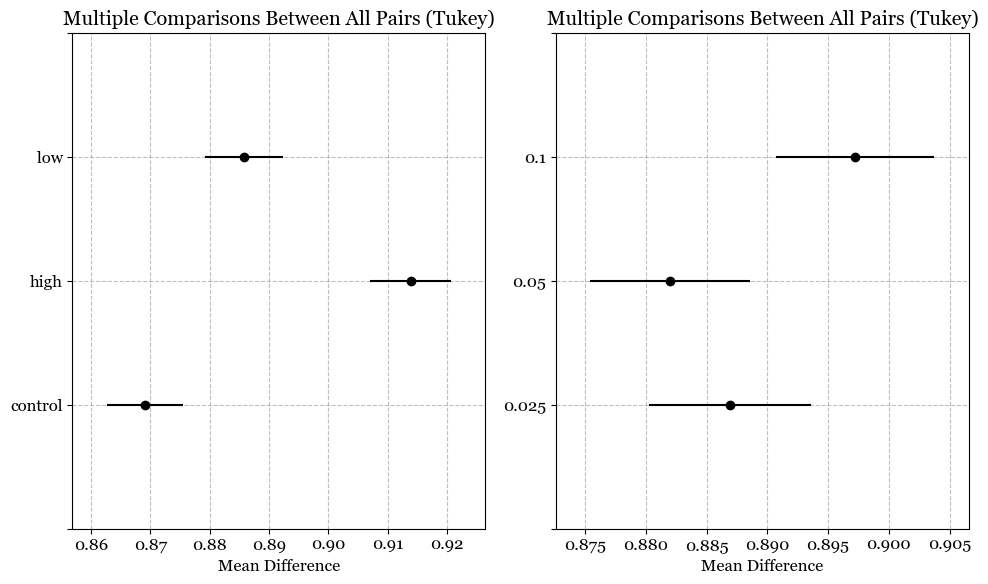

In [20]:
# Bonferroni-corrected post hoc test (Tukey's HSD)
posthoc = pairwise_tukeyhsd(endog=df_few_large['rt'], groups=df_few_large['difficulty'], alpha=0.05)
print("Tukey's HSD post hoc test for 'size_occl':\n",posthoc)

posthoc1 = pairwise_tukeyhsd(endog=df_few_large['rt'], groups=df_few_large['soa'], alpha=0.05)
print("Tukey's HSD post hoc test for 'soa':\n", posthoc1)

# Create a bar plot of the differences (optional)
fig, ax = plt.subplots(1,2,figsize=(8, 6))
posthoc.plot_simultaneous(xlabel='Mean Difference', ax=ax[0])
posthoc1.plot_simultaneous(xlabel='Mean Difference', ax=ax[1])
plt.tight_layout()
plt.show()

### Assumption Checks
Since it is repeated measures of Anova, we have three assumptions to meet:

1. Independence: Each of the observations should be independent.

2. Normality: The distribution of the response variable is normally distributed.

3. Sphericity: The variances of the differences between all combinations of related groups must be equal.

Due to nature of experimental design we have no reason to suspect assumption of independence to be violated.
We can test for 2nd and the 3rd via checks

<AxesSubplot:xlabel='rt', ylabel='Count'>

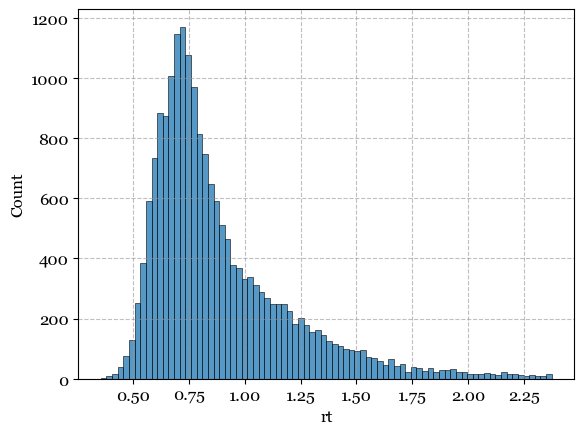

In [21]:
sns.histplot(df_few_large["rt"])

#sphere_check = pg.sphericity(df_few_large, dv="rt", within=['difficulty', 'soa'], subject= 'pt_num', method='mauchly', alpha=0.05)
#sphere_check

# Sphere check will not work due to both factors having 3 levels, pingouin only supports as long as one factor has 2 levels.
# As we have checked thoroughly other libraries does not have this check as well. For this reason we will later incorporate
# R-code to conduct the test for sphericity.

# Accuracy

### Main Anova size_occl X soa

In [22]:
df_acc = df
totalT = df_acc.groupby(['pt_num', 'size_occl', 'soa'], as_index=False)['acc'].count()
correctT = df_acc.groupby(['pt_num', 'size_occl', 'soa'], as_index=False)['acc'].sum()
totalT['acc'] = ((correctT['acc']/totalT['acc'].round(3)))*100

df_acc = pd.DataFrame(totalT)
xx = pg.rm_anova(data= df_acc, dv='acc', within=["size_occl", 'soa'], subject = "pt_num", detailed = True)
display(xx)
print(totalT)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,size_occl,4312.751074,1,28,4312.751074,224.239314,6.808913e-15,6.808913e-15,0.595240,1.000000
1,soa,1357.412994,2,56,678.706497,149.228451,3.643246e-23,1.224424e-21,0.316408,0.926650
2,size_occl * soa,243.282976,2,56,121.641488,35.985105,8.916943e-11,3.903258e-10,0.076602,0.925336


     pt_num   size_occl    soa        acc
0         1   few large  0.025  88.559322
1         1   few large  0.050  93.697479
2         1   few large  0.100  94.915254
3         1  many small  0.025  72.222222
4         1  many small  0.050  82.700422
..      ...         ...    ...        ...
169      30   few large  0.050  96.234310
170      30   few large  0.100  94.142259
171      30  many small  0.025  77.731092
172      30  many small  0.050  81.250000
173      30  many small  0.100  86.864407

[174 rows x 4 columns]


,0.025,0.050,0.100
0.025,1.000000e+00,0.016847,7.571858e-07
0.050,1.684657e-02,1.000000,1.824251e-02
0.100,7.571858e-07,0.018243,1.000000e+00


,few large,many small
few large,1.000000e+00,9.297042e-27
many small,9.297042e-27,1.000000e+00


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x25118db75e0>)

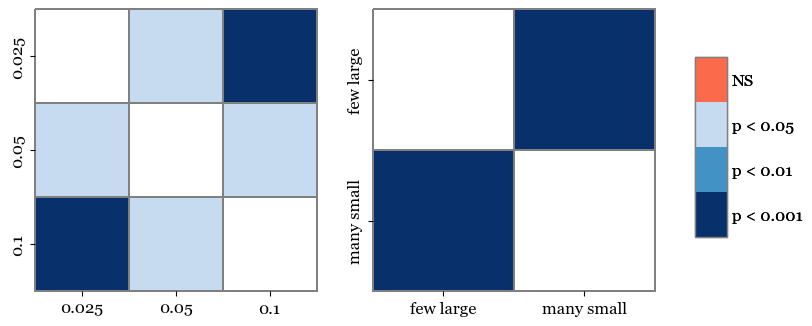

In [23]:
posthoc_soa = sp.posthoc_ttest(totalT, val_col= "acc", group_col= "soa", p_adjust='bonferroni')
display(posthoc_soa)

posthoc_size_occl = sp.posthoc_ttest(totalT, val_col= "acc", group_col= "size_occl", p_adjust='bonferroni')
display(posthoc_size_occl)

#PLotting them as signplots
fig, ax = plt.subplots(1,2,figsize=(8, 6))
cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.35, 0.04, 0.3]}
sp.sign_plot(posthoc_soa, **heatmap_args, ax =ax[0])

sp.sign_plot(posthoc_size_occl, **heatmap_args, ax= ax[1])

#Down below we do Tukey multiple comparisons

Tukey's HSD post hoc test for 'size_occl':
     Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2   meandiff p-adj  lower    upper  reject
-----------------------------------------------------------
few large many small  -9.9571   0.0 -11.4935 -8.4207   True
-----------------------------------------------------------
Tukey's HSD post hoc test for 'soa':
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
 0.025   0.05   3.7573 0.0073 0.8519 6.6627   True
 0.025    0.1   6.8302    0.0 3.9248 9.7356   True
  0.05    0.1   3.0729 0.0354 0.1675 5.9783   True
--------------------------------------------------


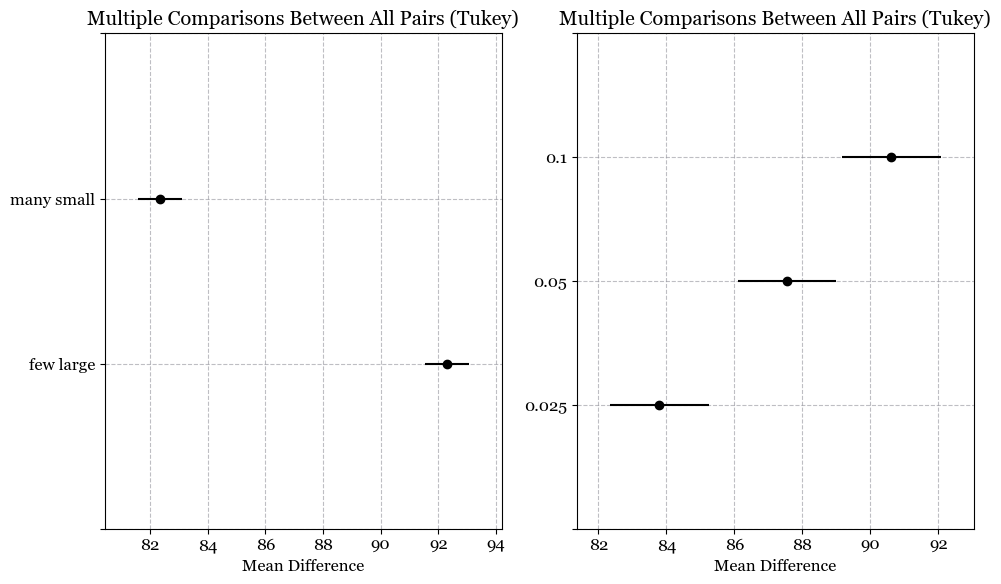

In [24]:
# Bonferroni-corrected post hoc test (Tukey's HSD)
posthoc = pairwise_tukeyhsd(endog=totalT['acc'], groups=totalT['size_occl'], alpha=0.05)
print("Tukey's HSD post hoc test for 'size_occl':\n",posthoc)

posthoc1 = pairwise_tukeyhsd(endog=totalT['acc'], groups=totalT['soa'], alpha=0.05)
print("Tukey's HSD post hoc test for 'soa':\n", posthoc1)

# Create a bar plot of the differences (optional)
fig, ax = plt.subplots(1,2,figsize=(8, 6))
posthoc.plot_simultaneous(xlabel='Mean Difference', ax=ax[0])
posthoc1.plot_simultaneous(xlabel='Mean Difference', ax=ax[1])
plt.tight_layout()
plt.show()

### Assumption Checks for Main Anova
Since it is repeated measures of Anova, we have three assumptions to meet:

1. Independence: Each of the observations should be independent.

2. Normality: The distribution of the response variable is normally distributed.

3. Sphericity: The variances of the differences between all combinations of related groups must be equal.

Due to nature of experimental design we have no reason to suspect assumption of independence to be violated.
We can test for 2nd and the 3rd via checks

SpherResults(spher=True, W=0.9193117326227495, chi2=2.271510152075061, dof=2, pval=0.32117951479735746)

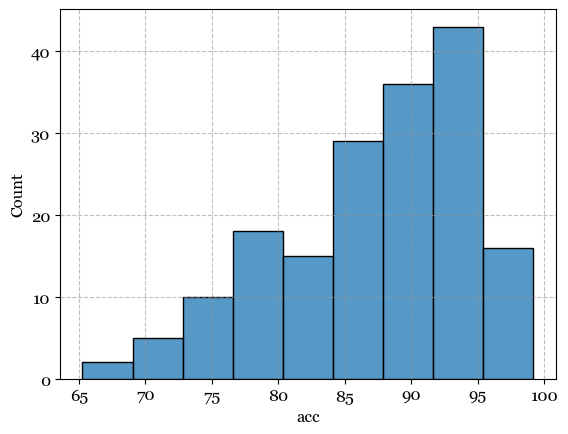

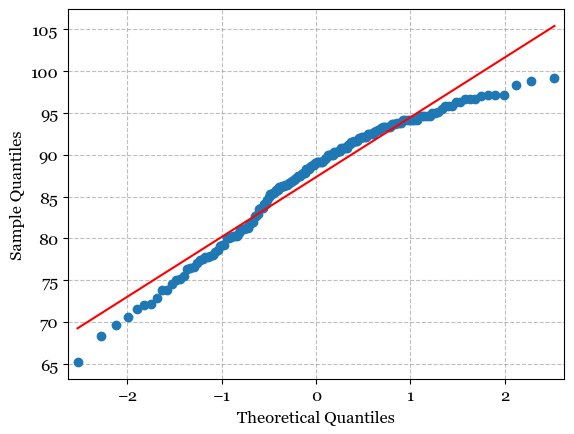

In [25]:
sns.histplot(totalT['acc'])
sm.qqplot(totalT['acc'], line = 's')

sphere_check = pg.sphericity(df_acc, dv="acc", within=['size_occl', 'soa'], subject= 'pt_num', method='mauchly', alpha=0.05)
sphere_check

### Sub Anova soa X difficulty on many_small occlusion

C:\Users\veoni\anaconda3\lib\site-packages\pingouin\distribution.py:515: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn(


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,difficulty,34326.045483,2,56,17163.022742,281.539183,6.030970e-30,7.587033e-21,0.752503,0.670115
1,soa,4188.349282,2,56,2094.174641,141.185323,1.337426e-22,2.112912e-22,0.270598,0.990189
2,difficulty * soa,1606.069986,4,112,401.517496,42.241070,1.485207e-21,3.685557e-09,0.124542,0.358394


,control,high,low
control,1.000000e+00,3.224941e-54,9.444031e-28
high,3.224941e-54,1.000000e+00,1.884489e-19
low,9.444031e-28,1.884489e-19,1.000000e+00


,0.025,0.050,0.100
0.025,1.000000,0.044566,0.000015
0.050,0.044566,1.000000,0.059172
0.100,0.000015,0.059172,1.000000


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x25119613c10>)

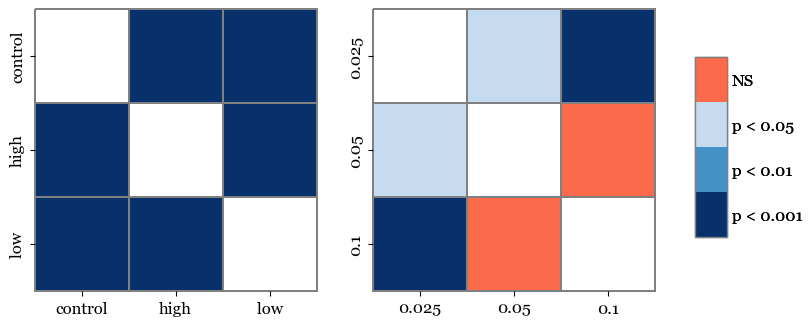

In [26]:
df_many_small_acc = df[(df['size_occl'] == "many small")]
totalT = df_many_small_acc.groupby(['pt_num', 'difficulty', 'soa', ], as_index=False)['acc'].count()
correctT = df_many_small_acc.groupby(['pt_num', 'difficulty', 'soa'], as_index=False)['acc'].sum()
totalT['acc'] = ((correctT['acc']/totalT['acc'].round(3)))*100

df_many_small_acc1 = pd.DataFrame(totalT)
xx = pg.rm_anova(data= df_many_small_acc1, dv='acc', within=["difficulty", 'soa'], subject = "pt_num", detailed = True)
display(xx)

posthoc_soa = sp.posthoc_ttest(totalT, val_col= "acc", group_col= "difficulty", p_adjust='bonferroni')
display(posthoc_soa)

posthoc_size_occl = sp.posthoc_ttest(totalT, val_col= "acc", group_col= "soa", p_adjust='bonferroni')
display(posthoc_size_occl)

#PLotting them as signplots
fig, ax = plt.subplots(1,2,figsize=(8, 6))
cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.35, 0.04, 0.3]}
sp.sign_plot(posthoc_soa, **heatmap_args, ax =ax[0])

sp.sign_plot(posthoc_size_occl, **heatmap_args, ax= ax[1])

#Down below we do Tukey multiple comparisons

Tukey's HSD post hoc test for 'size_occl':
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1 group2 meandiff p-adj  lower    upper   reject
------------------------------------------------------
control   high -28.0479   0.0 -30.9564 -25.1395   True
control    low -12.6771   0.0 -15.5855  -9.7686   True
   high    low  15.3709   0.0  12.4624  18.2793   True
------------------------------------------------------
Tukey's HSD post hoc test for 'soa':
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 0.025   0.05   5.4687 0.0222  0.6333 10.3042   True
 0.025    0.1     9.79    0.0  4.9546 14.6255   True
  0.05    0.1   4.3213 0.0905 -0.5141  9.1568  False
----------------------------------------------------


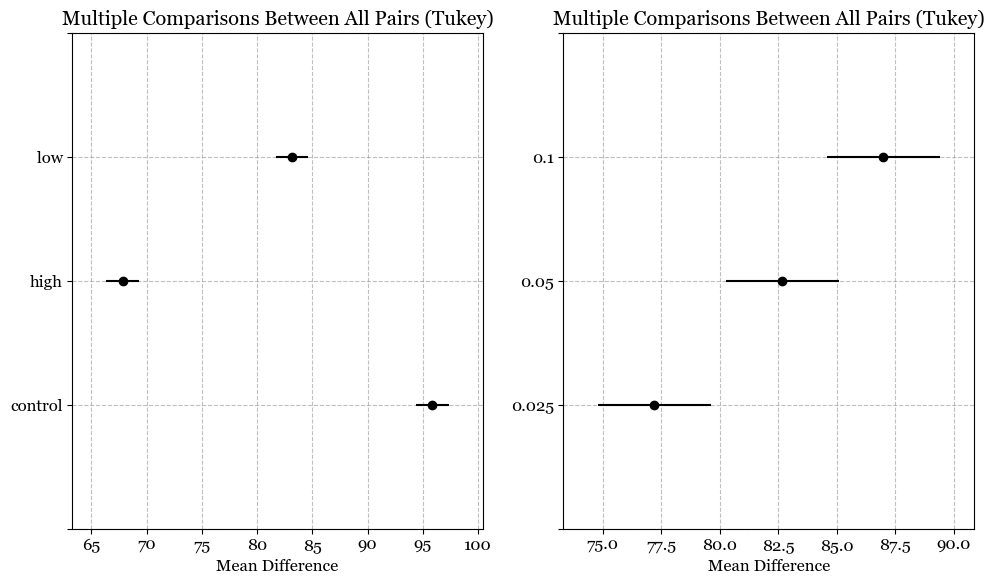

In [27]:
# Bonferroni-corrected post hoc test (Tukey's HSD)
posthoc = pairwise_tukeyhsd(endog=totalT['acc'], groups=totalT['difficulty'], alpha=0.05)
print("Tukey's HSD post hoc test for 'size_occl':\n",posthoc)

posthoc1 = pairwise_tukeyhsd(endog=totalT['acc'], groups=totalT['soa'], alpha=0.05)
print("Tukey's HSD post hoc test for 'soa':\n", posthoc1)

# Create a bar plot of the differences (optional)
fig, ax = plt.subplots(1,2,figsize=(8, 6))
posthoc.plot_simultaneous(xlabel='Mean Difference', ax=ax[0])
posthoc1.plot_simultaneous(xlabel='Mean Difference', ax=ax[1])
plt.tight_layout()
plt.show()

### Assumption Checks
Since it is repeated measures of Anova, we have three assumptions to meet:

1. Independence: Each of the observations should be independent.

2. Normality: The distribution of the response variable is normally distributed.

3. Sphericity: The variances of the differences between all combinations of related groups must be equal.

Due to nature of experimental design we have no reason to suspect assumption of independence to be violated.
We can test for 2nd and the 3rd via checks

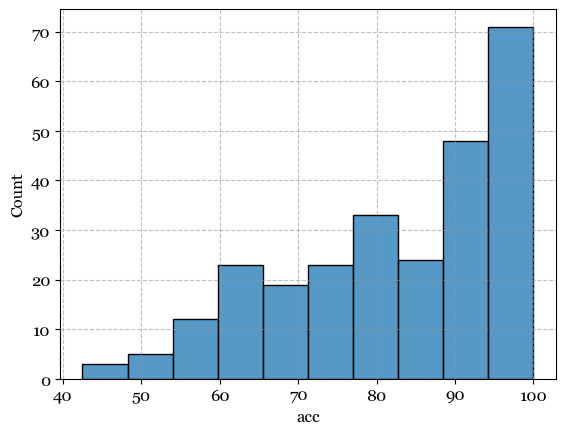

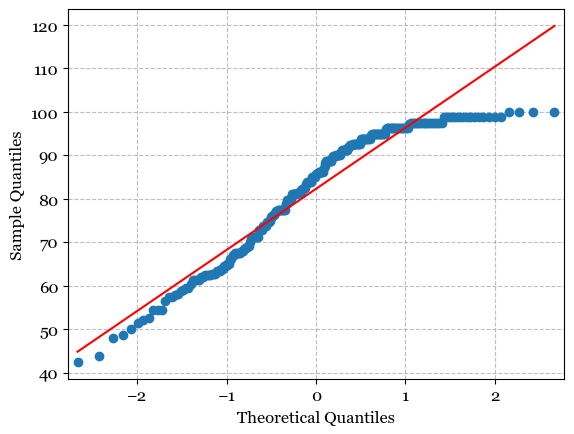

In [28]:
sns.histplot(totalT["acc"])
qqp = sm.qqplot(totalT["acc"], line = 's')
#sphere_check = pg.sphericity(df_many_small, dv="rt", within=['difficulty', 'soa'], subject= 'pt_num', method='mauchly', alpha=0.05)
#sphere_check

# Sphere check will not work due to both factors having 3 levels, pingouin only supports as long as one factor has 2 levels.
# As we have checked thoroughly other libraries does not have this check as well. For this reason we will later incorporate
# R-code to conduct the test for sphericity.

C:\Users\veoni\anaconda3\lib\site-packages\pingouin\distribution.py:515: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn(


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,difficulty,3422.788051,2,56,1711.394026,90.069414,3.166485e-18,1.480640e-13,0.462902,0.706891
1,soa,689.065806,2,56,344.532903,37.639180,4.363719e-11,1.768749e-10,0.147853,0.931630
2,difficulty * soa,490.121899,4,112,122.530475,14.990950,7.657116e-10,6.830495e-06,0.109855,0.493835


,control,high,low
control,1.000000e+00,2.548877e-24,1.807965e-09
high,2.548877e-24,1.000000e+00,1.001848e-10
low,1.807965e-09,1.001848e-10,1.000000e+00


,0.025,0.050,0.100
0.025,1.000000,0.075995,0.000024
0.050,0.075995,1.000000,0.025313
0.100,0.000024,0.025313,1.000000


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x25119e0efa0>)

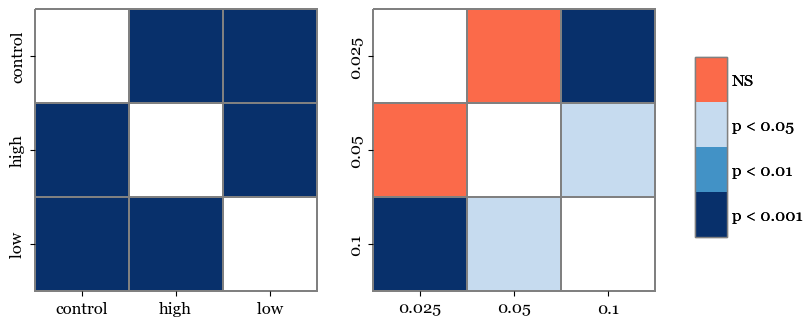

In [29]:
df_few_large_acc = df[(df['size_occl'] == "few large")]
totalT = df_few_large_acc.groupby(['pt_num', 'difficulty', 'soa', ], as_index=False)['acc'].count()
correctT = df_few_large_acc.groupby(['pt_num', 'difficulty', 'soa'], as_index=False)['acc'].sum()
totalT['acc'] = ((correctT['acc']/totalT['acc'].round(3)))*100

df_few_large_acc1 = pd.DataFrame(totalT)
xx = pg.rm_anova(data= df_few_large_acc1, dv='acc', within=["difficulty", 'soa'], subject = "pt_num", detailed = True)
display(xx)

posthoc_soa = sp.posthoc_ttest(totalT, val_col= "acc", group_col= "difficulty", p_adjust='bonferroni')
display(posthoc_soa)

posthoc_size_occl = sp.posthoc_ttest(totalT, val_col= "acc", group_col= "soa", p_adjust='bonferroni')
display(posthoc_size_occl)

#PLotting them as signplots
fig, ax = plt.subplots(1,2,figsize=(8, 6))
cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
heatmap_args = {'cmap': cmap, 'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.95, 0.35, 0.04, 0.3]}
sp.sign_plot(posthoc_soa, **heatmap_args, ax =ax[0])

sp.sign_plot(posthoc_size_occl, **heatmap_args, ax= ax[1])

#Down below we do Tukey multiple comparisons

Tukey's HSD post hoc test for 'size_occl':
  Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj  lower    upper  reject
-----------------------------------------------------
control   high  -8.7787   0.0 -10.3757 -7.1818   True
control    low  -3.2875   0.0  -4.8845 -1.6906   True
   high    low   5.4912   0.0   3.8942  7.0882   True
-----------------------------------------------------
Tukey's HSD post hoc test for 'soa':
 Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
 0.025   0.05   2.0924  0.035 0.1166 4.0682   True
 0.025    0.1   3.9782    0.0 2.0024 5.9541   True
  0.05    0.1   1.8859 0.0649  -0.09 3.8617  False
--------------------------------------------------


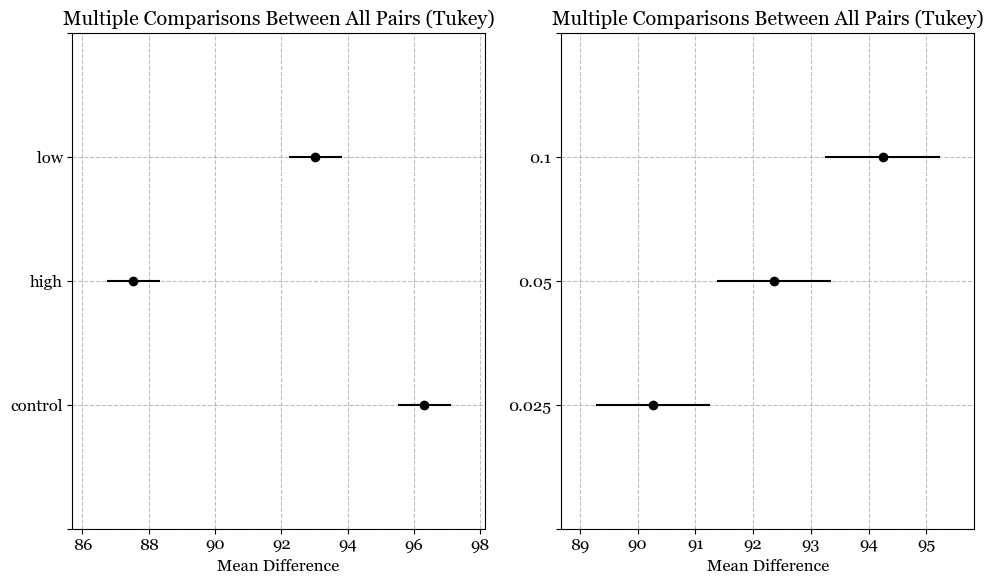

In [30]:
# Bonferroni-corrected post hoc test (Tukey's HSD)
posthoc = pairwise_tukeyhsd(endog=totalT['acc'], groups=totalT['difficulty'], alpha=0.05)
print("Tukey's HSD post hoc test for 'size_occl':\n",posthoc)

posthoc1 = pairwise_tukeyhsd(endog=totalT['acc'], groups=totalT['soa'], alpha=0.05)
print("Tukey's HSD post hoc test for 'soa':\n", posthoc1)

# Create a bar plot of the differences (optional)
fig, ax = plt.subplots(1,2,figsize=(8, 6))
posthoc.plot_simultaneous(xlabel='Mean Difference', ax=ax[0])
posthoc1.plot_simultaneous(xlabel='Mean Difference', ax=ax[1])
plt.tight_layout()
plt.show()

### Assumption Checks
Since it is repeated measures of Anova, we have three assumptions to meet:

1. Independence: Each of the observations should be independent.

2. Normality: The distribution of the response variable is normally distributed.

3. Sphericity: The variances of the differences between all combinations of related groups must be equal.

Due to nature of experimental design we have no reason to suspect assumption of independence to be violated.
We can test for 2nd and the 3rd via checks

     pt_num difficulty    soa         acc
0         1    control  0.025   97.468354
1         1    control  0.050  100.000000
2         1    control  0.100   98.734177
3         1       high  0.025   78.205128
4         1       high  0.050   86.250000
..      ...        ...    ...         ...
256      30       high  0.050   95.000000
257      30       high  0.100   92.500000
258      30        low  0.025   92.405063
259      30        low  0.050   95.000000
260      30        low  0.100   93.670886

[261 rows x 4 columns]


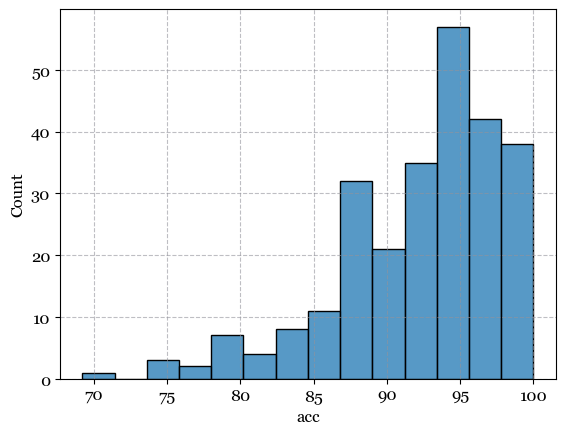

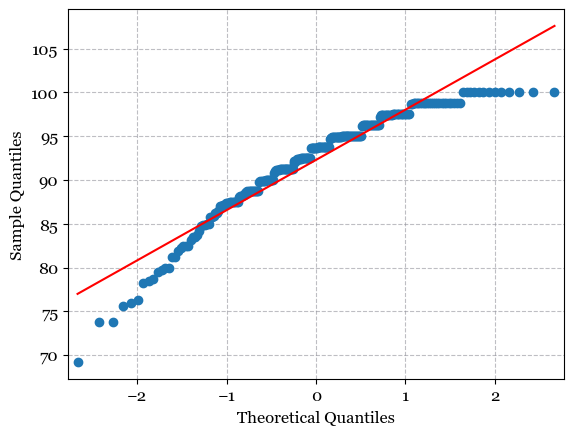

In [41]:
sns.histplot(totalT["acc"])
qqp = sm.qqplot(totalT["acc"], line = 's')
#sphere_check = pg.sphericity(df_many_small, dv="rt", within=['difficulty', 'soa'], subject= 'pt_num', method='mauchly', alpha=0.05)
#sphere_check

# Sphere check will not work due to both factors having 3 levels, pingouin only supports as long as one factor has 2 levels.
# As we have checked thoroughly other libraries does not have this check as well. For this reason we will later incorporate
# R-code to conduct the test for sphericity.
print(totalT)